# **Fake News**

Using NLP more specifically Word2Vec and Bag Of Words to detect fake news.

## **Data Importation**


In [ ]:
! pip install vaderSentiment
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import gensim
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import pandas as pd
import re
import nltk #pour télécharger les ressources nécessaires de la bibliothèque NLTK, notamment les tokenizer (punkt) et les stopwords (stopwords).
nltk.download('punkt')
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Loading the dataset
df = pd.read_csv('bbc-text.csv',delimiter=",")

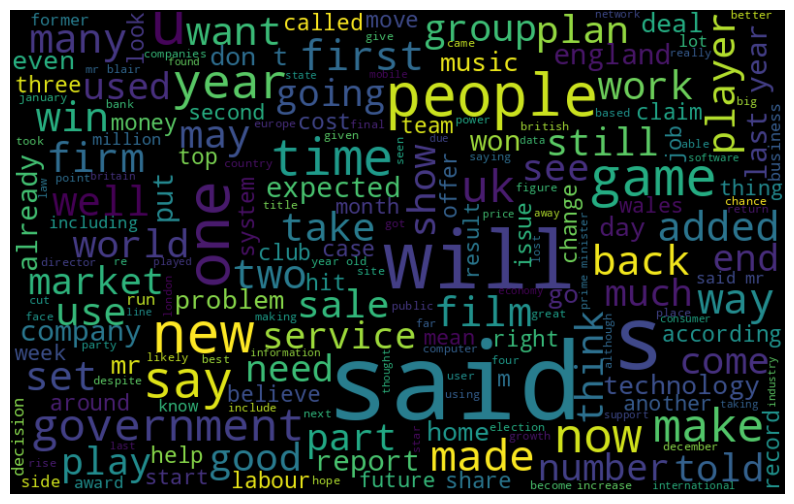

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Collecting all words
all_words = ' '.join([text for text in df['text']])

# Visualizing the most frequent words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Data Preprocessing**

In [ ]:
from nltk.corpus import stopwords  #Imports stopwords from the nltk.corpus library
stop_words = set(stopwords.words('english')) #Loads English stopwords into a set for faster searching.

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text) #Deletes all the numbers in the text.
    text = re.sub(r'[^\w\s]', '', text) #Removes punctuation and special characters from text.
    text = [word for word in text.split() if word not in stop_words] #divides the text into individual words and checks that each word is not in the list of stopwords. Words that are not stopwords are kept..
    text = ' '.join(text) #reassembles pre-processed words into a single text string.
    return text

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download required resources
nltk.download('stopwords')
nltk.download('punkt')

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming or Lemmatization
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Example usage
df['text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Converting the column category into a numeric one
# Define a dictionary mapping each unique label to an integer value
label_map = {label: i for i, label in enumerate(df['category'].unique())}
# Convert the labels in your dataframe to integers using the label map
df['category'] = df['category'].map(label_map)

## **Word2Vec**

In [ ]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np



# Tokenize the text data
tokenized_data = [d.split() for d in df['text']]

# Train Word2Vec model
model = Word2Vec(tokenized_data, vector_size=100, window=5, min_count=5, workers=4)

# Create word vectors for training data
vectors = []
for doc in tokenized_data:
    doc_vectors = []
    for word in doc:
        if word in model.wv:
            doc_vectors.append(model.wv[word])
    if doc_vectors:
        vectors.append(np.mean(doc_vectors, axis=0))
    else:
        vectors.append(np.zeros(100))  # Use zero vector if no words are present in the model vocabulary

# Convert to numpy array
vectors = np.array(vectors)
labels=df["category"]

## **Logistic Regression Model**

In [ ]:
from sklearn.metrics import classification_report
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2, random_state=42)

# Train the logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.950561797752809
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        82
           1       0.90      0.94      0.92       101
           2       1.00      0.97      0.98        98
           3       0.97      0.93      0.95        81
           4       0.94      0.96      0.95        83

    accuracy                           0.95       445
   macro avg       0.95      0.95      0.95       445
weighted avg       0.95      0.95      0.95       445



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## **Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.952808988764045


In [ ]:
# Define the inverse label map
inv_label_map = {v: k for k, v in label_map.items()}
# Map the integer labels back to their original string values
df['category_name'] = df['category'].map(inv_label_map)

In [ ]:
!pip install textblob
from textblob import TextBlob
# Define a function to extract the sentiment polarity of the text using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity
# Apply the function to the 'text' column of the DataFrame and store the result in a new column 'sentiment'
df['sentiment'] = df['text'].apply(get_sentiment)
df.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,category,text,category_name,sentiment
0,0,tv futur hand viewer home theatr system plasma...,tech,0.047273
1,1,worldcom boss left book alon former worldcom b...,business,-0.091667
2,2,tiger wari farrel gambl leicest say rush make ...,sport,0.053846
3,2,yead face newcastl fa cup premiership side new...,sport,-0.072727
4,3,ocean twelv raid box offic ocean twelv crime c...,entertainment,0.096992


In [ ]:
# Create an empty list to store the results
results = []

# Loop through each news article in the dataset
for i in range(len(df)):

    sentiment=df['sentiment'][i]

    # Classify the news article as fake or real based on the sentiment score
    if sentiment < 0:
        result = 'Fake'
    elif sentiment >= 0:
        result = 'Real'
    else:
        result = 'Unknown'

    # Add the result to the list of results
    results.append(result)

# Add the results to the dataset
df['Result_sentiment'] = results

In [ ]:
df.head(10)

,category,text,category_name,sentiment,Result_sentiment
0,0,tv futur hand viewer home theatr system plasma...,tech,0.047273,Real
1,1,worldcom boss left book alon former worldcom b...,business,-0.091667,Fake
2,2,tiger wari farrel gambl leicest say rush make ...,sport,0.053846,Real
3,2,yead face newcastl fa cup premiership side new...,sport,-0.072727,Fake
4,3,ocean twelv raid box offic ocean twelv crime c...,entertainment,0.096992,Real
5,4,howard hit back mongrel jibe michael howard sa...,politics,0.239815,Real
6,4,blair prepar name poll date toni blair like na...,politics,0.276296,Real
7,2,henman hope end dubai third seed tim henman sl...,sport,0.057143,Real
8,2,wilkinson fit face edinburgh england captain j...,sport,0.117063,Real
9,3,last star war children sixth final star war mo...,entertainment,-0.093056,Fake


## **Bag Of Words**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Vectorize the preprocessed text data
vectorizer = CountVectorizer()
X_text = vectorizer.fit_transform(df['text'])

In [ ]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_text,df['category'], test_size=0.2, random_state=42)

# Train the logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9573033707865168


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
